In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Jensen et al. (2005), Figure 5: Thresholds for Activation of Rabbit
Retinal Ganglion Cells with Relatively Large, Extracellular Microelectrodes.
Investigative Ophthalmology & Visual Science:46(4).

In [2]:
def threshold_current_sekirnjak(el_area):
    """Returns the threshold current needed for a given electrode area (Sekirnjak et al., 2006)"""
    return 0.08 * el_area ** 0.7

In [3]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
jensen = dict()
jensen['E125'] = dict()
jensen['E500'] = dict()

# Axons
jensen['E125']['axon'] = dict()
jensen['E125']['axon']['0.1'] = np.array([0, 3.49149, 49.49211, 4.93797, 99.58362,
                                          9.51688, 149.75063, 12.19050,  198.90872,
                                          36.68733, 299.46237, 183.41754, 398.49234,
                                          349.14896]).reshape((-1, 2))
jensen['E125']['axon']['1.0'] = np.array([0, 0.69783, 49.57602, 1.07461, 99.40599,
                                          2.77146, 149.33927, 4.01945, 199.13481,
                                          12.55909, 299.34143, 39.71534, 398.80122,
                                          80.58422]).reshape((-1, 2))
jensen['E125']['axon']['10.0'] = np.array([0, 0.69251, 48.94730, 1.00000, 98.98513,
                                           2.56788, 149.53263, 3.99084, 198.69358,
                                           12.77565, 298.90724, 39.42255, 399.21882,
                                           70.96821]).reshape((-1, 2))

jensen['E500']['axon'] = dict()
jensen['E500']['axon']['0.1'] = np.array([0, 14.34171, 48.75000, 24.59424, 99.58333,
                                          49.36522, 148.33333, 100.31863, 198.75000,
                                          187.24588, 298.75000, 351.63856, 397.91667,
                                          459.12382]).reshape((-1, 2))
jensen['E500']['axon']['1.0'] = np.array([0, 2.79305, 49.56506, 3.45266, 98.39239,
                                          6.93181, 147.97507, 21.78898, 198.56416,
                                          26.93464, 298.41882, 59.93593, 398.31972,
                                          103.40334]).reshape((-1, 2))
jensen['E500']['axon']['10.0'] = np.array([0, 2.21828, 49.01961, 2.37154, 98.47063,
                                           5.18242, 147.91303, 11.88743, 197.81488,
                                           20.63321, 296.86145, 43.74543, 396.36101,
                                           72.77994]).reshape((-1, 2))

# SL responses
jensen['E125']['SL'] = dict()
jensen['E125']['SL']['0.1'] = np.array([0, 0.77518, 48.38813, 4.97207, 98.86690,
                                        10.42399, 148.14874, 25.75066, 196.50495,
                                        42.85309, 296.74433, 82.74288, 395.96234,
                                        131.10489]).reshape((-1, 2))
jensen['E125']['SL']['1.0'] = np.array([0, 0.40849, 47.46181, 1.09473, 98.31536,
                                        3.22338, 148.30039, 5.91579, 197.87361,
                                        8.17544, 297.61156, 14.20009, 397.89608,
                                        24.65805]).reshape((-1, 2))
jensen['E125']['SL']['10.0'] = np.array([0, 0.36592, 49.45055, 1.23467, 98.90110,
                                         2.91601, 149.45055, 5.95179, 198.35165,
                                         7.23028, 299.45055, 14.28662, 398.90110,
                                         29.16008]).reshape((-1, 2))

jensen['E500']['SL'] = dict()
jensen['E500']['SL']['0.1'] = np.array([0, 8.52228, 50.82873, 13.76857, 101.65746,
                                        25.28004, 148.61878, 32.13249, 200.00000,
                                        34.80701, 301.10497, 65.98488, 400.00000,
                                        121.15277]).reshape((-1, 2))
jensen['E500']['SL']['1.0'] = np.array([0, 2.88451, 47.17229, 3.58008, 96.92153,
                                        6.01963, 146.76337, 8.35448, 197.77023,
                                        10.36906, 297.88597, 25.79769, 399.35962,
                                        38.48525]).reshape((-1, 2))
jensen['E500']['SL']['10.0'] = np.array([0, 3.00428, 50.00000, 3.71647, 100.54348,
                                         5.05424, 150.00000, 6.87471, 198.91304,
                                         10.27984, 300.00000, 13.86912, 400.00000,
                                         37.45896]).reshape((-1, 2))


jensen['E125']['LL'] = dict()
jensen['E125']['LL']['0.1'] = np.array([0, 38.82682, 47.06352, 76.21877, 96.57676,
                                        116.87098, 146.74433, 147.13995, 195.57932,
                                        288.68307, 294.68560, 575.82915, 395.21226,
                                        615.09233]).reshape((-1, 2))
jensen['E125']['LL']['1.0'] = np.array([0, 4.49046, 47.19976, 6.01296, 97.75382,
                                        10.52264, 147.92603, 13.01833, 197.91105,
                                        23.89225, 298.28541, 34.33320, 398.65978,
                                        49.33687]).reshape((-1, 2))
jensen['E125']['LL']['10.0'] = np.array([0, 0.50609, 51.09890, 0.72303, 101.09890,
                                         1.40568, 149.45055, 2.86911, 200.00000,
                                         3.31991, 298.90110, 5.95179, 400.00000,
                                         7.71479]).reshape((-1, 2))

jensen['E500']['LL'] = dict()
jensen['E500']['LL']['0.1'] = np.array([0, 79.94251, 50.82873, 278.25594, 99.44751,
                                        326.50429, 150.82873, 287.29848, 201.10497,
                                        296.63488, 300.55249, 421.69650, 400.00000,
                                        544.64198]).reshape((-1, 2))
jensen['E500']['LL']['1.0'] = np.array([0, 11.05193, 46.18471, 27.71486, 97.29188,
                                        27.94228, 146.63992, 34.12103, 197.18386,
                                        34.95237, 297.52334, 54.69462, 399.17445,
                                        56.48695]).reshape((-1, 2))
jensen['E500']['LL']['10.0'] = np.array([0, 3.10055, 48.91304, 3.89721, 100.00000,
                                         3.46186, 150.00000, 3.12456, 200.00000,
                                         3.62959, 300.54348, 9.49791, 400.54348,
                                         6.50496]).reshape((-1, 2))

# Functions
-----------------

Following are all utily funcions used in this script.

In [4]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample, tau_inl=18.0 / 1000, delay_inl=40.0 / 1000,
                 lweight=0.636):
        super(GanglionCellResponse, self).__init__(tsample, tau_inl=tau_inl,
                                                   delay_inl=delay_inl,
                                                   lweight=lweight, aweight=0)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [5]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [6]:
# Monophasic pulse train
def get_pulse_train(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 20.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    pulse_train = np.array([])
    for j in range(int(np.ceil(stim_dur * freq))):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

In [7]:
def find_sl_ll(resp, stim, tm, verbose=False):
    """Finds the SL and LL responses of a pulse train"""
    
    # Find stimulus on-set in stimulus
    idx_onset = np.where(np.abs(stim.data) == np.abs(stim.data).max())[0][0]
    dur_onset = idx_onset * stim.tsample
    
    # Translate to indexing of `resp` (might have different `tsample`)
    idx_onset = int(np.floor(dur_onset / resp.tsample))
    
    if verbose:
        print('stim onset: dur=%f, idx=%d' % (dur_onset, idx_onset))
        
    activity = resp.data.squeeze()
    
    # SL response within 10ms of stimulus onset
    sl_dur = 10.0 / 1000
    sl_size = int(np.round(sl_dur / resp.tsample))
    sl_resp = activity[idx_onset: idx_onset + sl_size]
    t_sl = (sl_resp.argmax() + idx_onset) * resp.tsample
    y_sl = sl_resp.max()
    
    # LL response after ~40ms of stimulus onset
    ll_delay = int(np.floor(tm.delay_inl / resp.tsample))
    ll_resp = activity[idx_onset + ll_delay:]
    t_ll = (ll_resp.argmax() + idx_onset + ll_delay) * resp.tsample
    y_ll = ll_resp.max()
    
    if verbose:
        print('SL=%f at t=%f, LL=%f at t=%f' % (y_sl, t_sl, y_ll, t_ll))
        
    return [t_sl, y_sl], [t_ll, y_ll]

In [8]:
def run_fig5_ax_sl_ll(heights, pulse_dur, implant, retina, amp_th_axon,
                        amp_th_sl, amp_th_ll, verbose=False):
    tsample = 0.005 / 1000
    stim_dur = 500.0 / 1000
    stim_freq = 2.0
    amp_in = [0.1, 1, 10]
    
    delay_inl = 40.0 / 1000
    
    tau_inl = 5.0 / 1000
    lweight = 0.636
    ecs_scale = 1.0
    
    # Don't execute the full model cascade: We're interested in RGC-like responses
    tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                              tau_inl=tau_inl, lweight=lweight)
    
    # We need to define some activity value that corresponds to threshold activity.
    # We do this by executing the model at the first data point of the Jensen paper.
    # Whatever activity is produced by these parameters, we'll take as threshold
    # activity, and will try to find the matching current for all subsequent data points
    implant[0].height = heights[0]
    stim = get_pulse_train('cathodic', stim_freq, amp_th_sl, pulse_dur,
                           stim_dur, tsample)

    # Axonal response
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=True,
                             ecs_scale=ecs_scale, engine='joblib',
                             rsample=1, verbose=False)
    ax_match = mov.data.max()
    
    # SL response
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                             ecs_scale=ecs_scale, engine='joblib',
                             rsample=1, verbose=False)
    sl_max, _ = find_sl_ll(mov, stim, tm)
    sl_match = sl_max[1]

    # LL response
    stim = get_pulse_train('cathodic', stim_freq, amp_th_ll, pulse_dur,
                           stim_dur, tsample)
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                             ecs_scale=ecs_scale,
                             engine='joblib', rsample=1, verbose=False)
    _, ll_max = find_sl_ll(mov, stim, tm)
    ll_match = ll_max[1]
    
    if verbose:
        print('- Threshold: Axon=%f, SL=%f, LL=%f' %  (ax_match, sl_match, ll_match))

    amp_match_ax = []
    amp_match_sl = []
    amp_match_ll = []
    for ht in heights:
        if verbose:
            print('- Processing height %f' % ht)
        implant[0].height = ht
        ax_out = []
        sl_out = []
        ll_out = []
        for amp in amp_in:
            stim = get_pulse_train('cathodic', stim_freq, amp, pulse_dur,
                                   stim_dur, tsample)
            idx_onset = stim.data.nonzero()[0][0]
            
            # Axonal response
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=True,
                                     ecs_scale=ecs_scale, engine='joblib',
                                     rsample=1, verbose=False)
            ax_out.append(mov.data.max())

            # SL / LL responses
            mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False,
                                     ecs_scale=ecs_scale, engine='joblib',
                                     rsample=1, verbose=False)
            sl_max, ll_max = find_sl_ll(mov, stim, tm)
            sl_out.append(sl_max[1])
            ll_out.append(ll_max[1])
        amp_match_ax.append(fit_amps(amp_in, ax_out, ax_match))
        amp_match_sl.append(fit_amps(amp_in, sl_out, sl_match))
        amp_match_ll.append(fit_amps(amp_in, ll_out, ll_match))
        
    return amp_match_ax, amp_match_sl, amp_match_ll

# Run model
-----------------

In [9]:
model = dict()

r_sampling = 100
axon_lambda = 2
verbose = False

for diam in [125.0, 500.0]:
    # Create an implant
    ename = 'E%d' % diam
    implant = e2cm.ElectrodeArray('epiretinal', diam / 2.0, -500, -500, 50, ename)

    # Create a retina
    retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                        xlo=implant[0].x_center, xhi=implant[0].x_center,
                        ylo=implant[0].y_center, yhi=implant[0].y_center)
    
    # Run model and store output
    print('Running %s' % ename)
    model[ename] = dict()
    model[ename]['implant'] = implant
    model[ename]['heights'] = np.array([0, 50, 100, 150, 200, 300, 400])
    model[ename]['pulsedur'] = np.array([0.1, 1, 10])
    model[ename]['SL'] = dict()
    model[ename]['LL'] = dict()
    model[ename]['axon'] = dict()
    for pd in model[ename]['pulsedur']:
        cond = '%.1f' % pd
        
        ax, sl, ll = run_fig5_ax_sl_ll(model[ename]['heights'], pd, implant, retina,
                                       jensen[ename]['axon'][cond][0, 1],
                                       jensen[ename]['SL'][cond][0, 1], 
                                       jensen[ename]['LL'][cond][0, 1], verbose)
        model[ename]['axon'][cond] = ax
        model[ename]['SL'][cond] = sl
        model[ename]['LL'][cond] = ll

Running E125
Running E500


# Results
---------

axon response


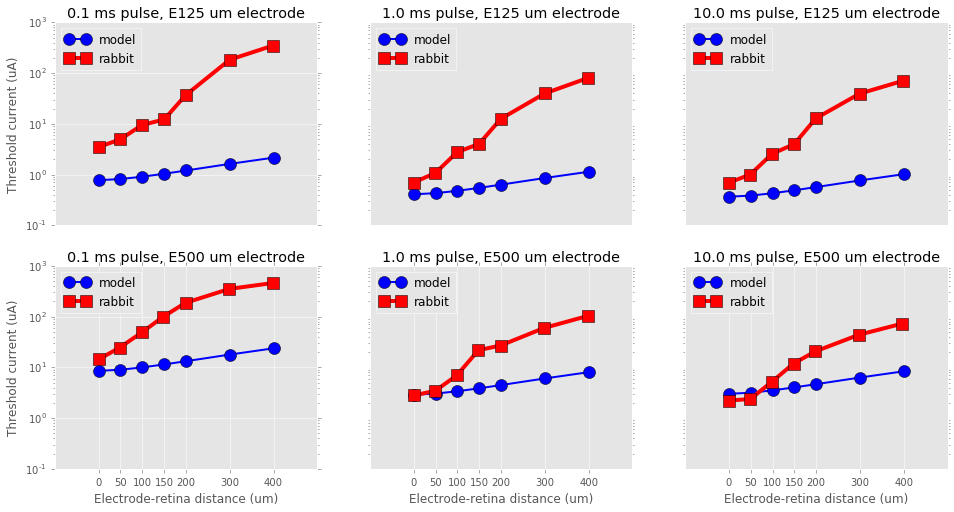

In [10]:
plt.figure(figsize=(16, 8))

rtype = 'axon'
print('%s response' % rtype)

subplot = 1
for ename in ['E125', 'E500']:
    for pd in model[ename]['pulsedur']:
        cond = '%.1f' % pd
        plt.subplot(2, 3, subplot)
        if ename in model:
            if rtype in model[ename]:
                plt.semilogy(model[ename]['heights'], model[ename][rtype][cond],
                             'o-b', linewidth=2, markersize=12, label='model')
        plt.semilogy(jensen[ename][rtype][cond][:, 0], jensen[ename][rtype][cond][:, 1],
                     's-r', linewidth=4, markersize=12, label='rabbit')
        
        if subplot > 3:
            plt.xticks(model[ename]['heights'])
            plt.xlabel('Electrode-retina distance (um)')
        else:
            plt.xticks([])
        if (subplot - 1) % 3 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        plt.title('%s ms pulse, %s um electrode' % (cond, ename))
        plt.legend(loc='upper left')
        plt.ylim(0.1, 1000)
        plt.xlim(-100, 500)
        
        subplot += 1

SL response


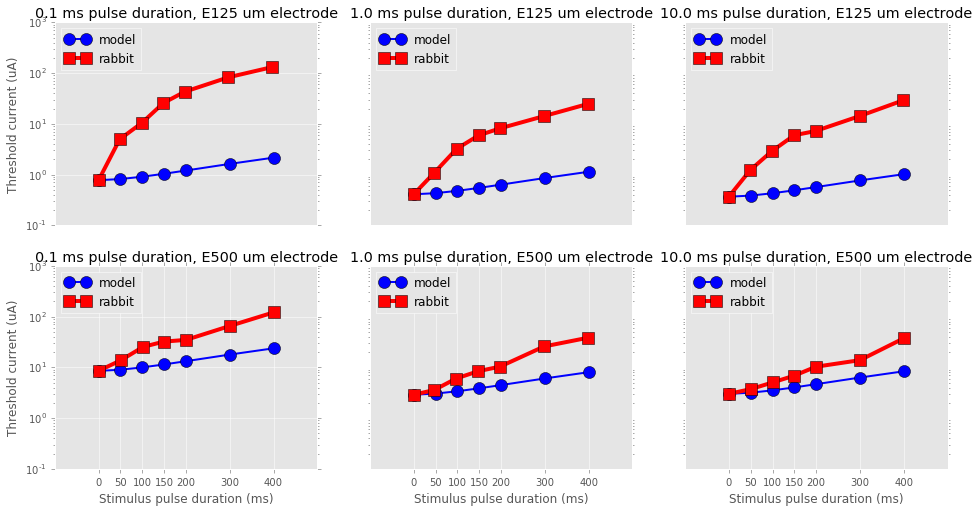

In [11]:
plt.figure(figsize=(16, 8))

rtype = 'SL'
print('%s response' % rtype)

subplot = 1
for ename in ['E125', 'E500']:
    for pd in model[ename]['pulsedur']:
        cond = '%.1f' % pd
        plt.subplot(2, 3, subplot)
        if ename in model:
            if rtype in model[ename]:
                plt.semilogy(model[ename]['heights'], model[ename][rtype][cond],
                             'o-b', linewidth=2, markersize=12, label='model')
        plt.semilogy(jensen[ename][rtype][cond][:, 0], jensen[ename][rtype][cond][:, 1],
                     's-r', linewidth=4, markersize=12, label='rabbit')
        
        if subplot > 3:
            plt.xticks(model[ename]['heights'])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 3 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        plt.title('%s ms pulse duration, %s um electrode' % (cond, ename))
        plt.legend(loc='upper left')
        plt.ylim(0.1, 1000)
        plt.xlim(-100, 500)
        
        subplot += 1

LL response


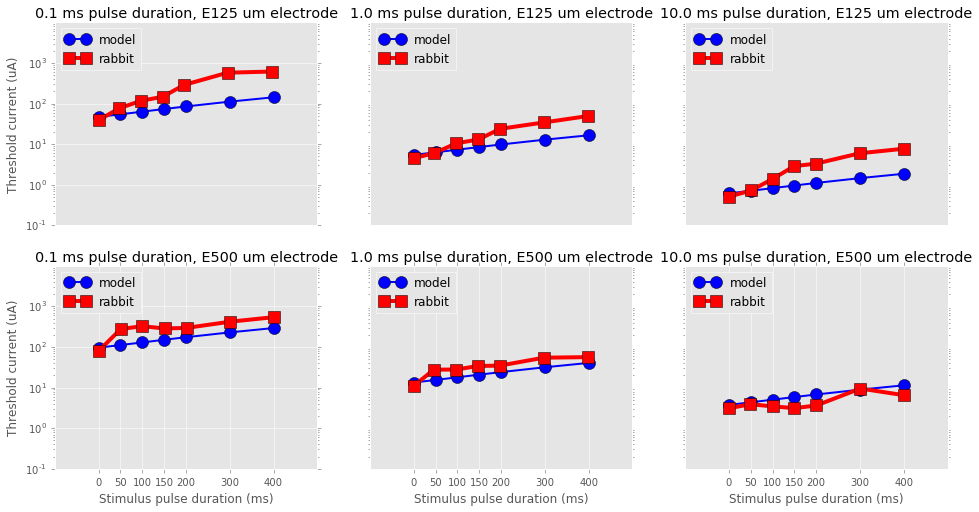

In [12]:
plt.figure(figsize=(16, 8))

rtype = 'LL'
print('%s response' % rtype)

subplot = 1
for ename in ['E125', 'E500']:
    for pd in model[ename]['pulsedur']:
        cond = '%.1f' % pd
        plt.subplot(2, 3, subplot)
        if ename in model:
            if rtype in model[ename]:
                plt.semilogy(model[ename]['heights'], model[ename][rtype][cond],
                             'o-b', linewidth=2, markersize=12, label='model')
        plt.semilogy(jensen[ename][rtype][cond][:, 0], jensen[ename][rtype][cond][:, 1],
                     's-r', linewidth=4, markersize=12, label='rabbit')
        
        if subplot > 3:
            plt.xticks(model[ename]['heights'])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 3 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        plt.title('%s ms pulse duration, %s um electrode' % (cond, ename))
        plt.legend(loc='upper left')
        plt.ylim(0.1, 10000)
        plt.xlim(-100, 500)
        
        subplot += 1